### CS5228 Mini Project Team 07 - Exploratory Data Analysis (EDA)

#### Objective

This notebook aims to perform EDA on the training dataset to:
- Visualize the distribution of features using Matplotlib or Seaborn. 
- Analyze correlations among features and the target variable (churn).  
- Perform feature selection using PCA.

The output of this notebook create a pickle file `cleaned_datasets.pkl` containing variants of train and test datasets. Structure:
```python
{
    "standard_scale": 
    {
        "train": train_df_with_standard_scaling,
        "test": test_df_with_standard_scaling
    },

    "min_max_scale": 
    {
        "train": train_df_with_min_max_scaling,
        "test": test_df_with_min_max_scaling
    },

    "standard_scale_pca": 
    {
        "train": train_df_with_standard_scaling_and_pca,
        "test": test_df_with_standard_scaling_and_pca
    },

    "min_max_scale_pca": 
    {
        "train": train_df_with_min_max_scaling_and_pca,
        "test": test_df_with_min_max_scaling_and_pca
    }
}
```

#### Imports

In [25]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Read the raw and processed dataset

In [26]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    dataests = pickle.load(f)

raw_train_df = pd.read_csv('./dataset/churn-bigml-80.csv')
min_max_train_df = dataests['min_max_scale']['train']
standard_train_df = dataests['standard_scale']['train']
min_max_test_df = dataests['min_max_scale']['test']
standard_test_df = dataests['standard_scale']['test']

In [27]:
numerical_columns = ['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']
categorical_columns = ['State', 'Area code', 'International plan', 'Voice mail plan', 'Churn']

#### Visualize the distribution of the numerical features in raw_train_df 

There are a lot of 0s for number of vmail messages while the rest of the numerical features have a normal distribution shape roughly

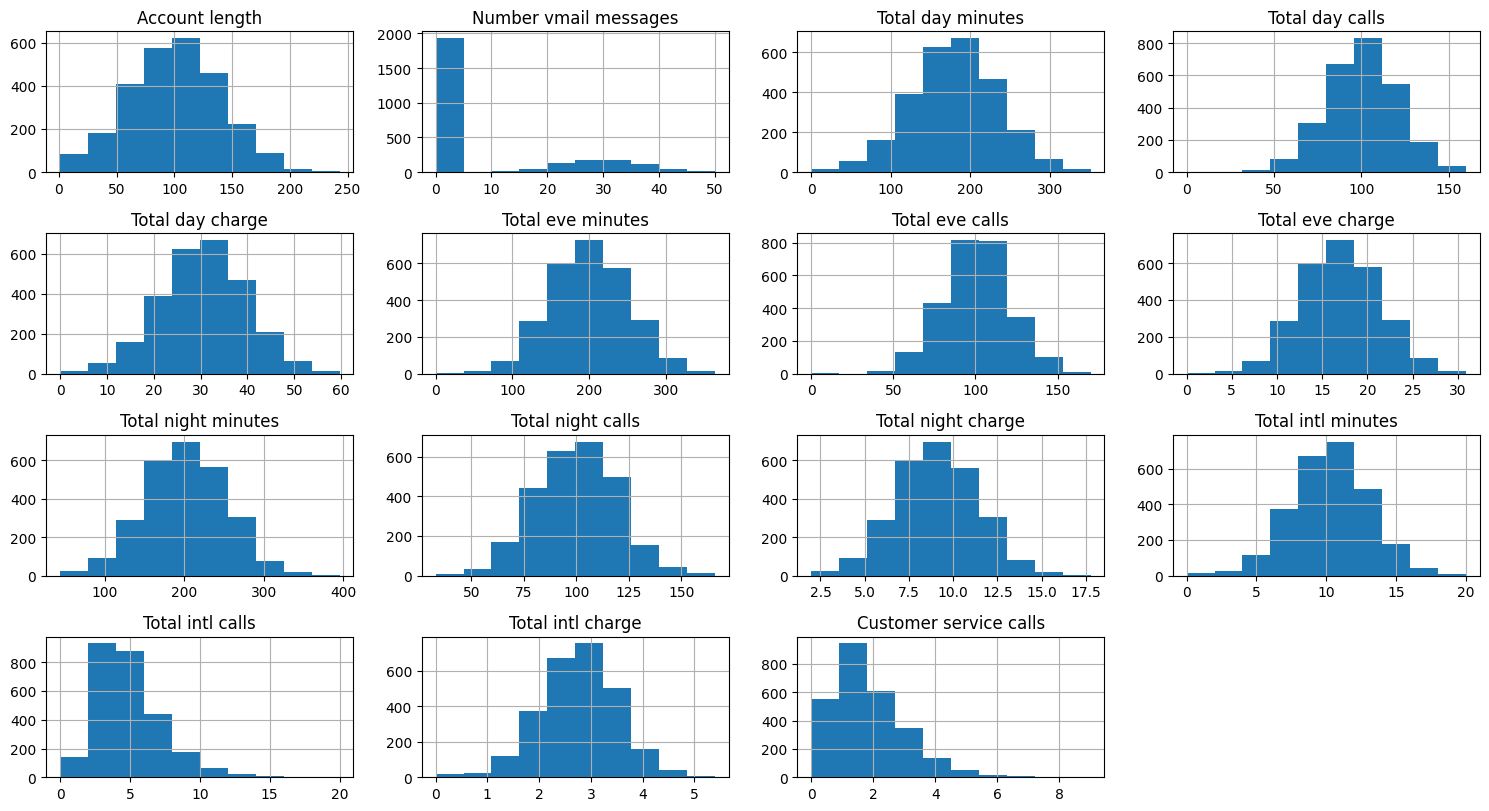

In [28]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(5, 4, i+1)
    raw_train_df[col].hist(ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

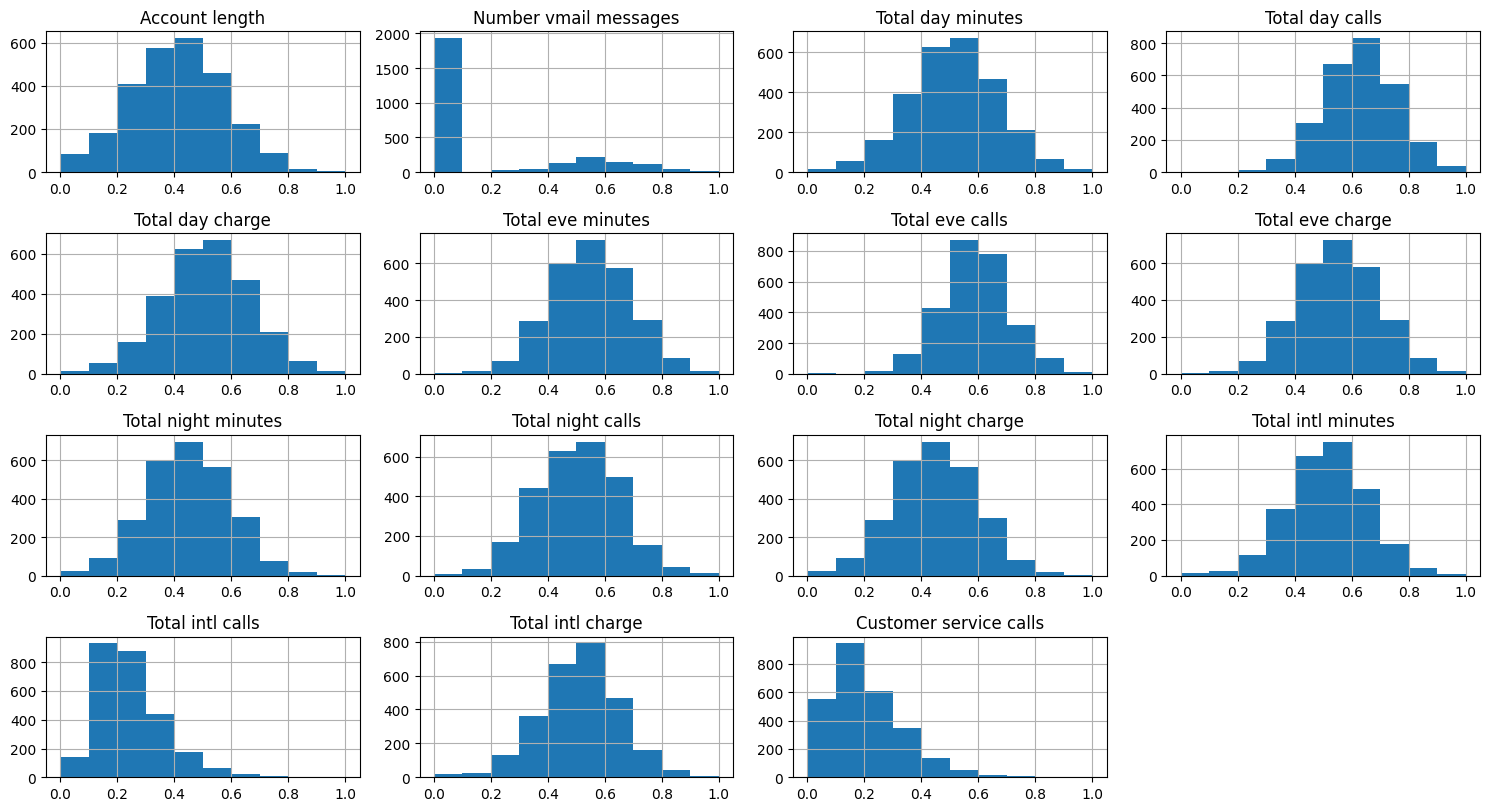

In [29]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(5, 4, i+1)
    min_max_train_df[col].hist(ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

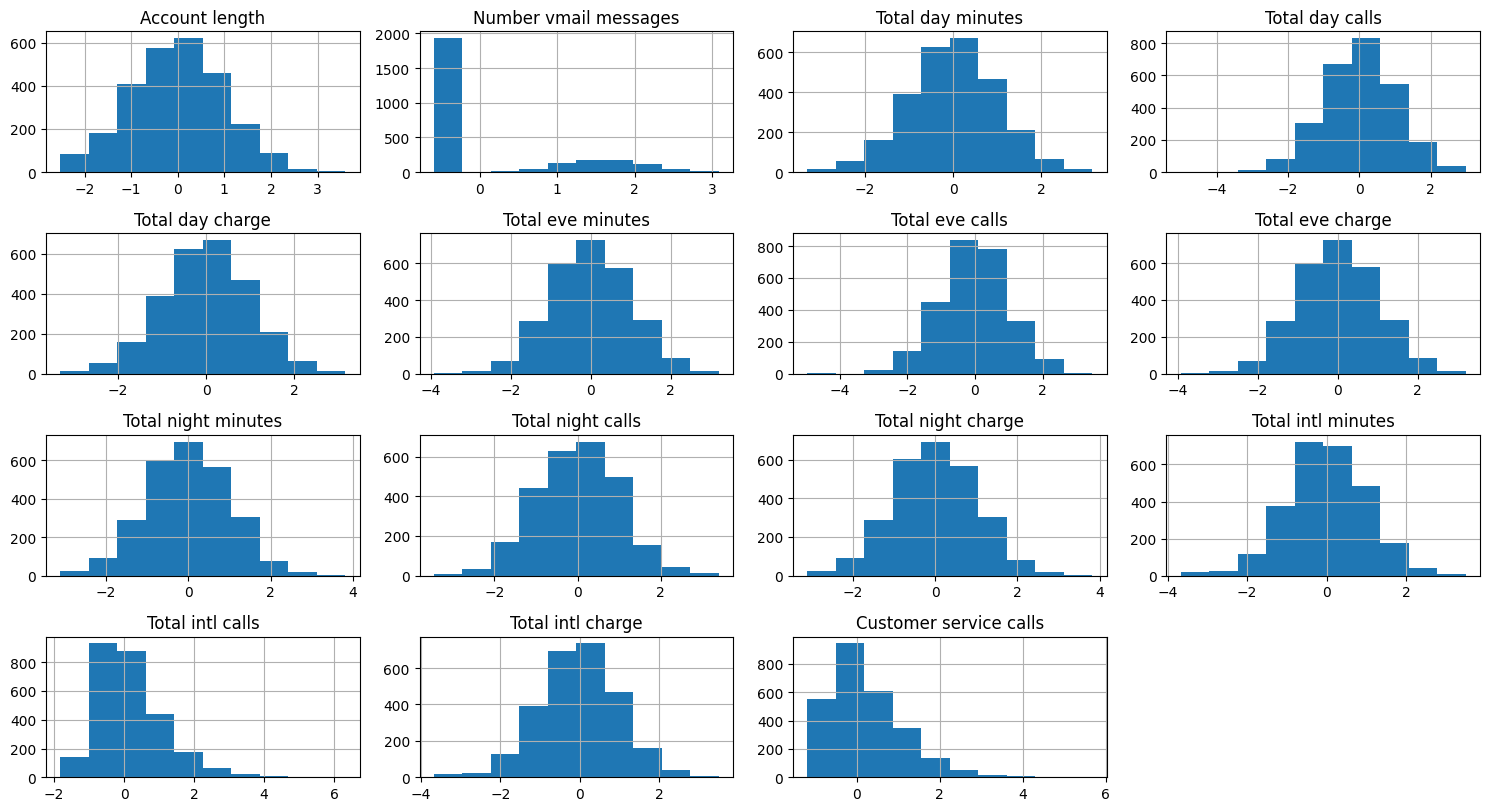

In [30]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(5, 4, i+1)
    standard_train_df[col].hist(ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

#### Correlation heatmap between feature and target (Churn)

- At various time of the day, minutes and charge have perfect correlation (which means the underlying price is roughly constant), meaning we should drop these features in feature selection.
- Voice mail plan and number vmail messages have high correlation - this is because people who do not subscribe to a voice mail plan will have zero voice message as observed in the histogram.


As such, at the feature selection phase we may want to drop the following features having high correlation with the rest:
- Charge at different time of the day
- Voice mail plan which is a boolean flag

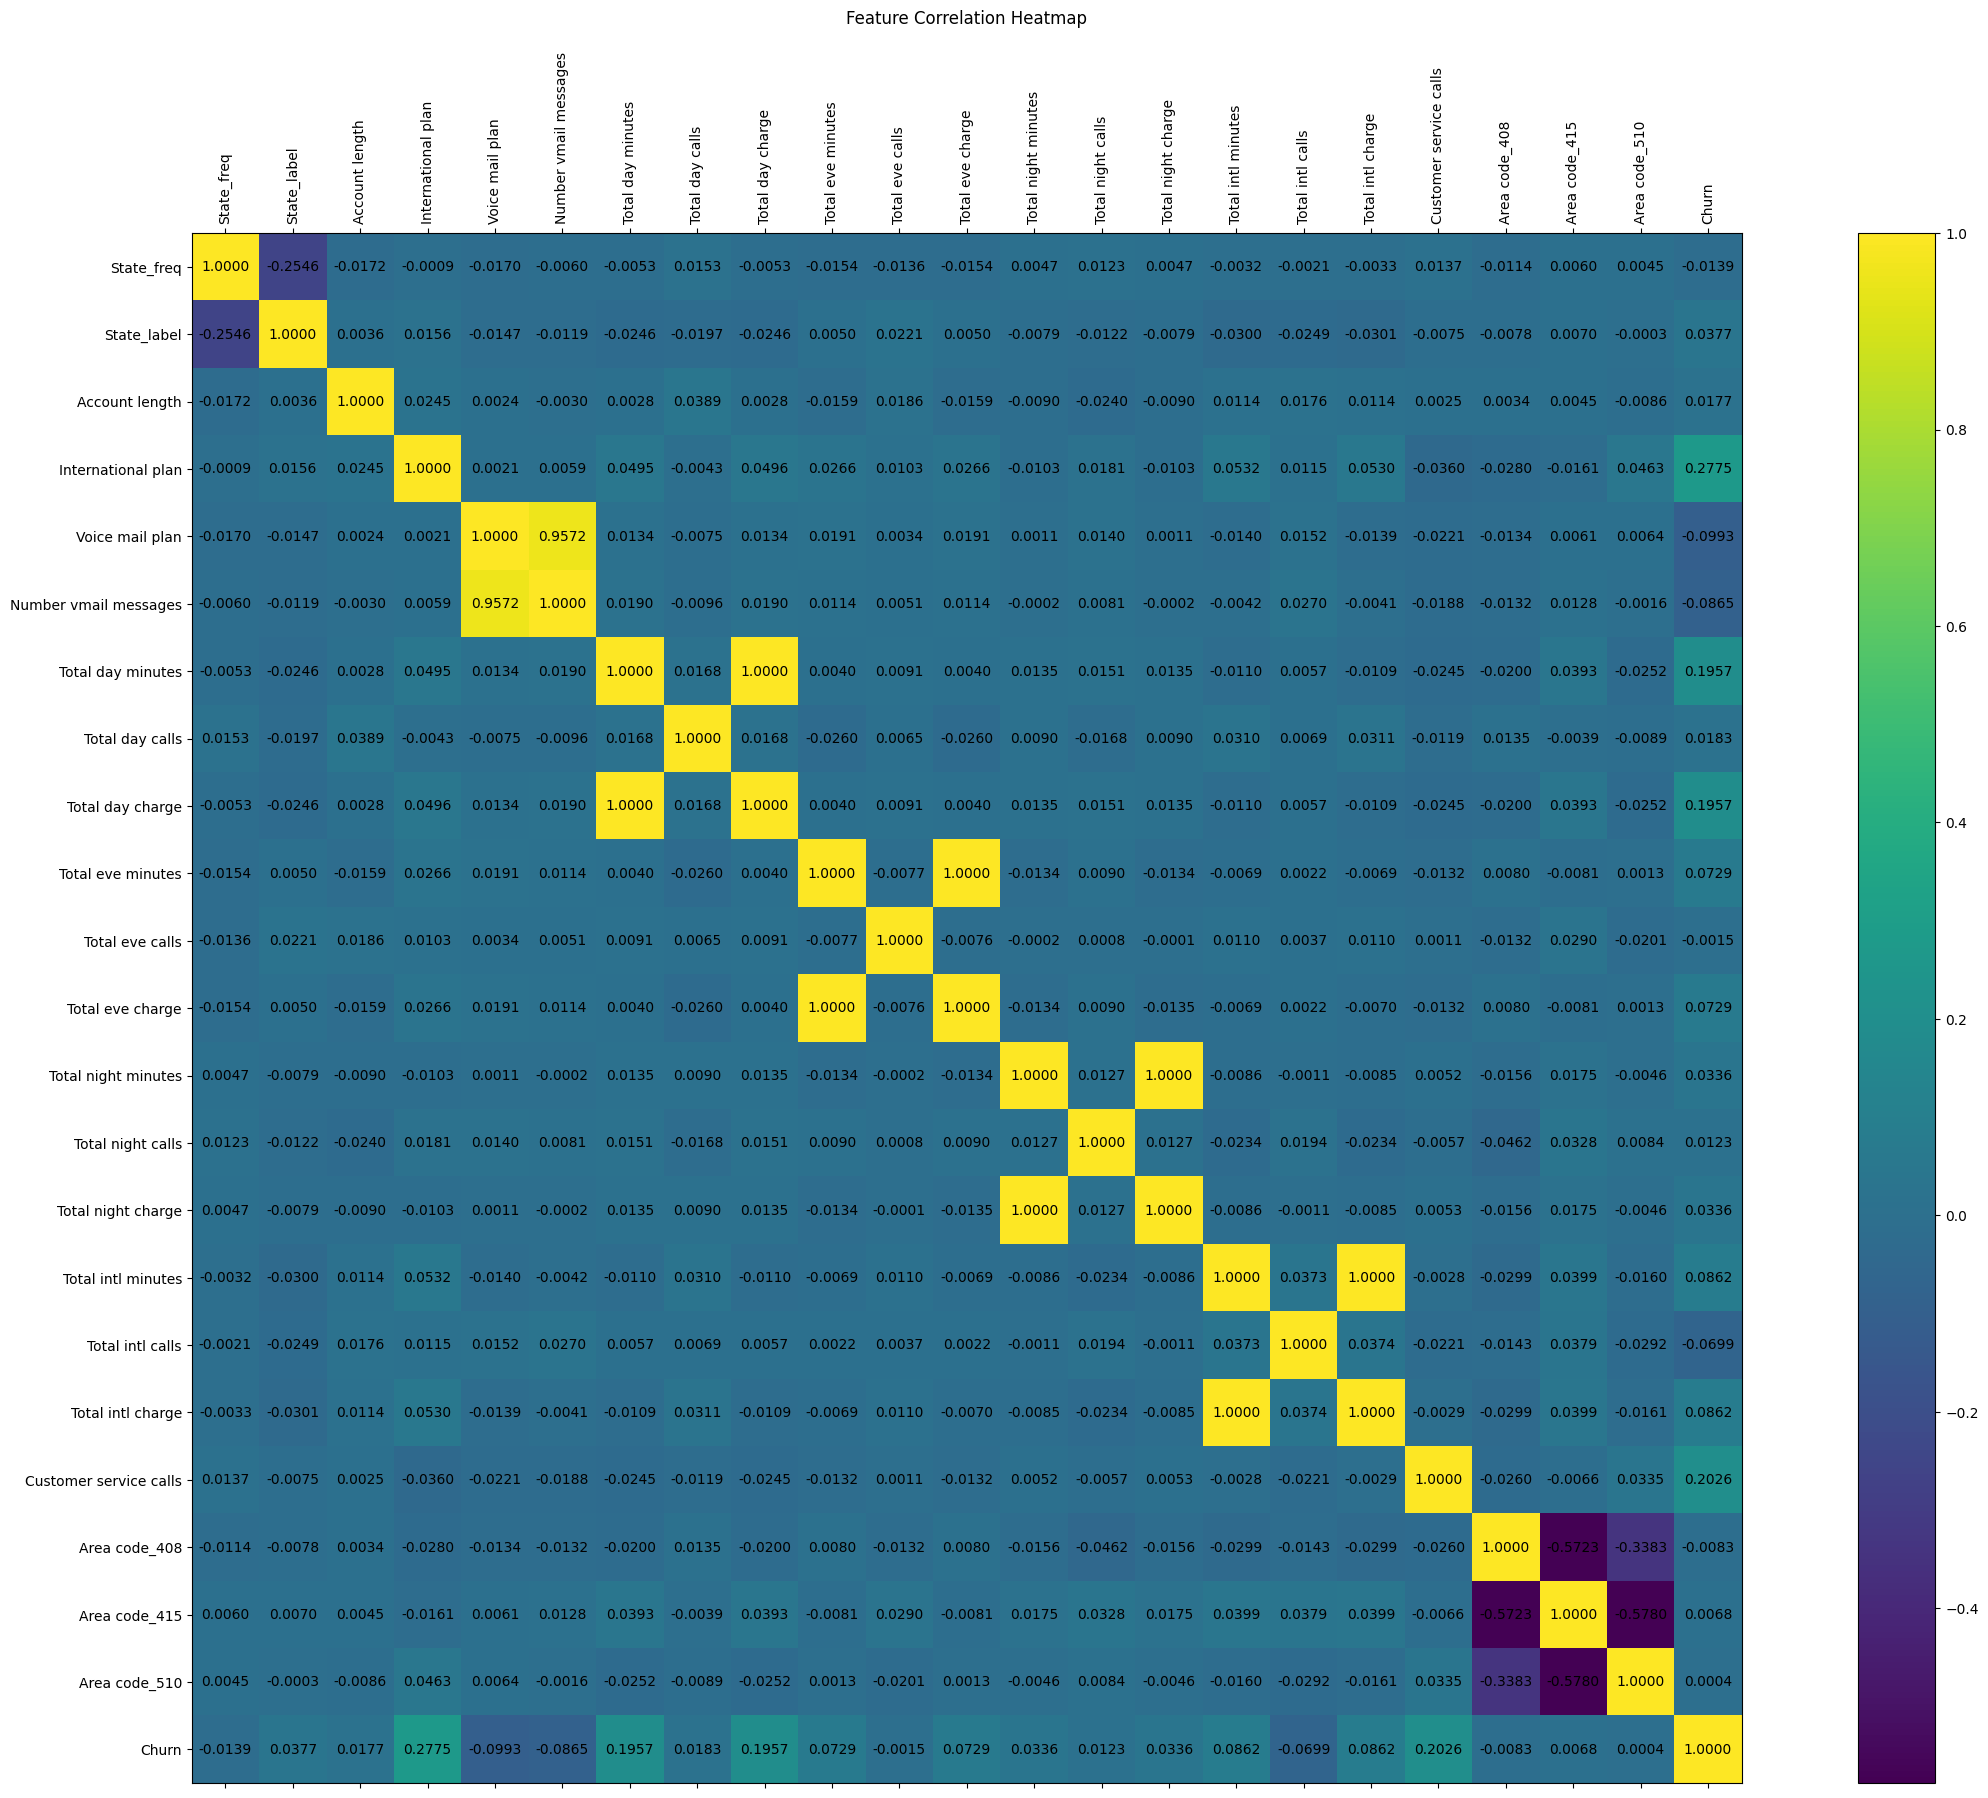

In [31]:
correlation = min_max_train_df.corr()
plt.figure(figsize=(30, 20))
plt.matshow(correlation, fignum=1)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation='vertical')
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()
for i in range(len(correlation.columns)):
    for j in range(len(correlation.columns)):
        plt.text(j, i, f"{correlation.iloc[i, j]:.4f}", ha='center', va='center', color='black')

plt.title("Feature Correlation Heatmap", pad=20)
plt.show()


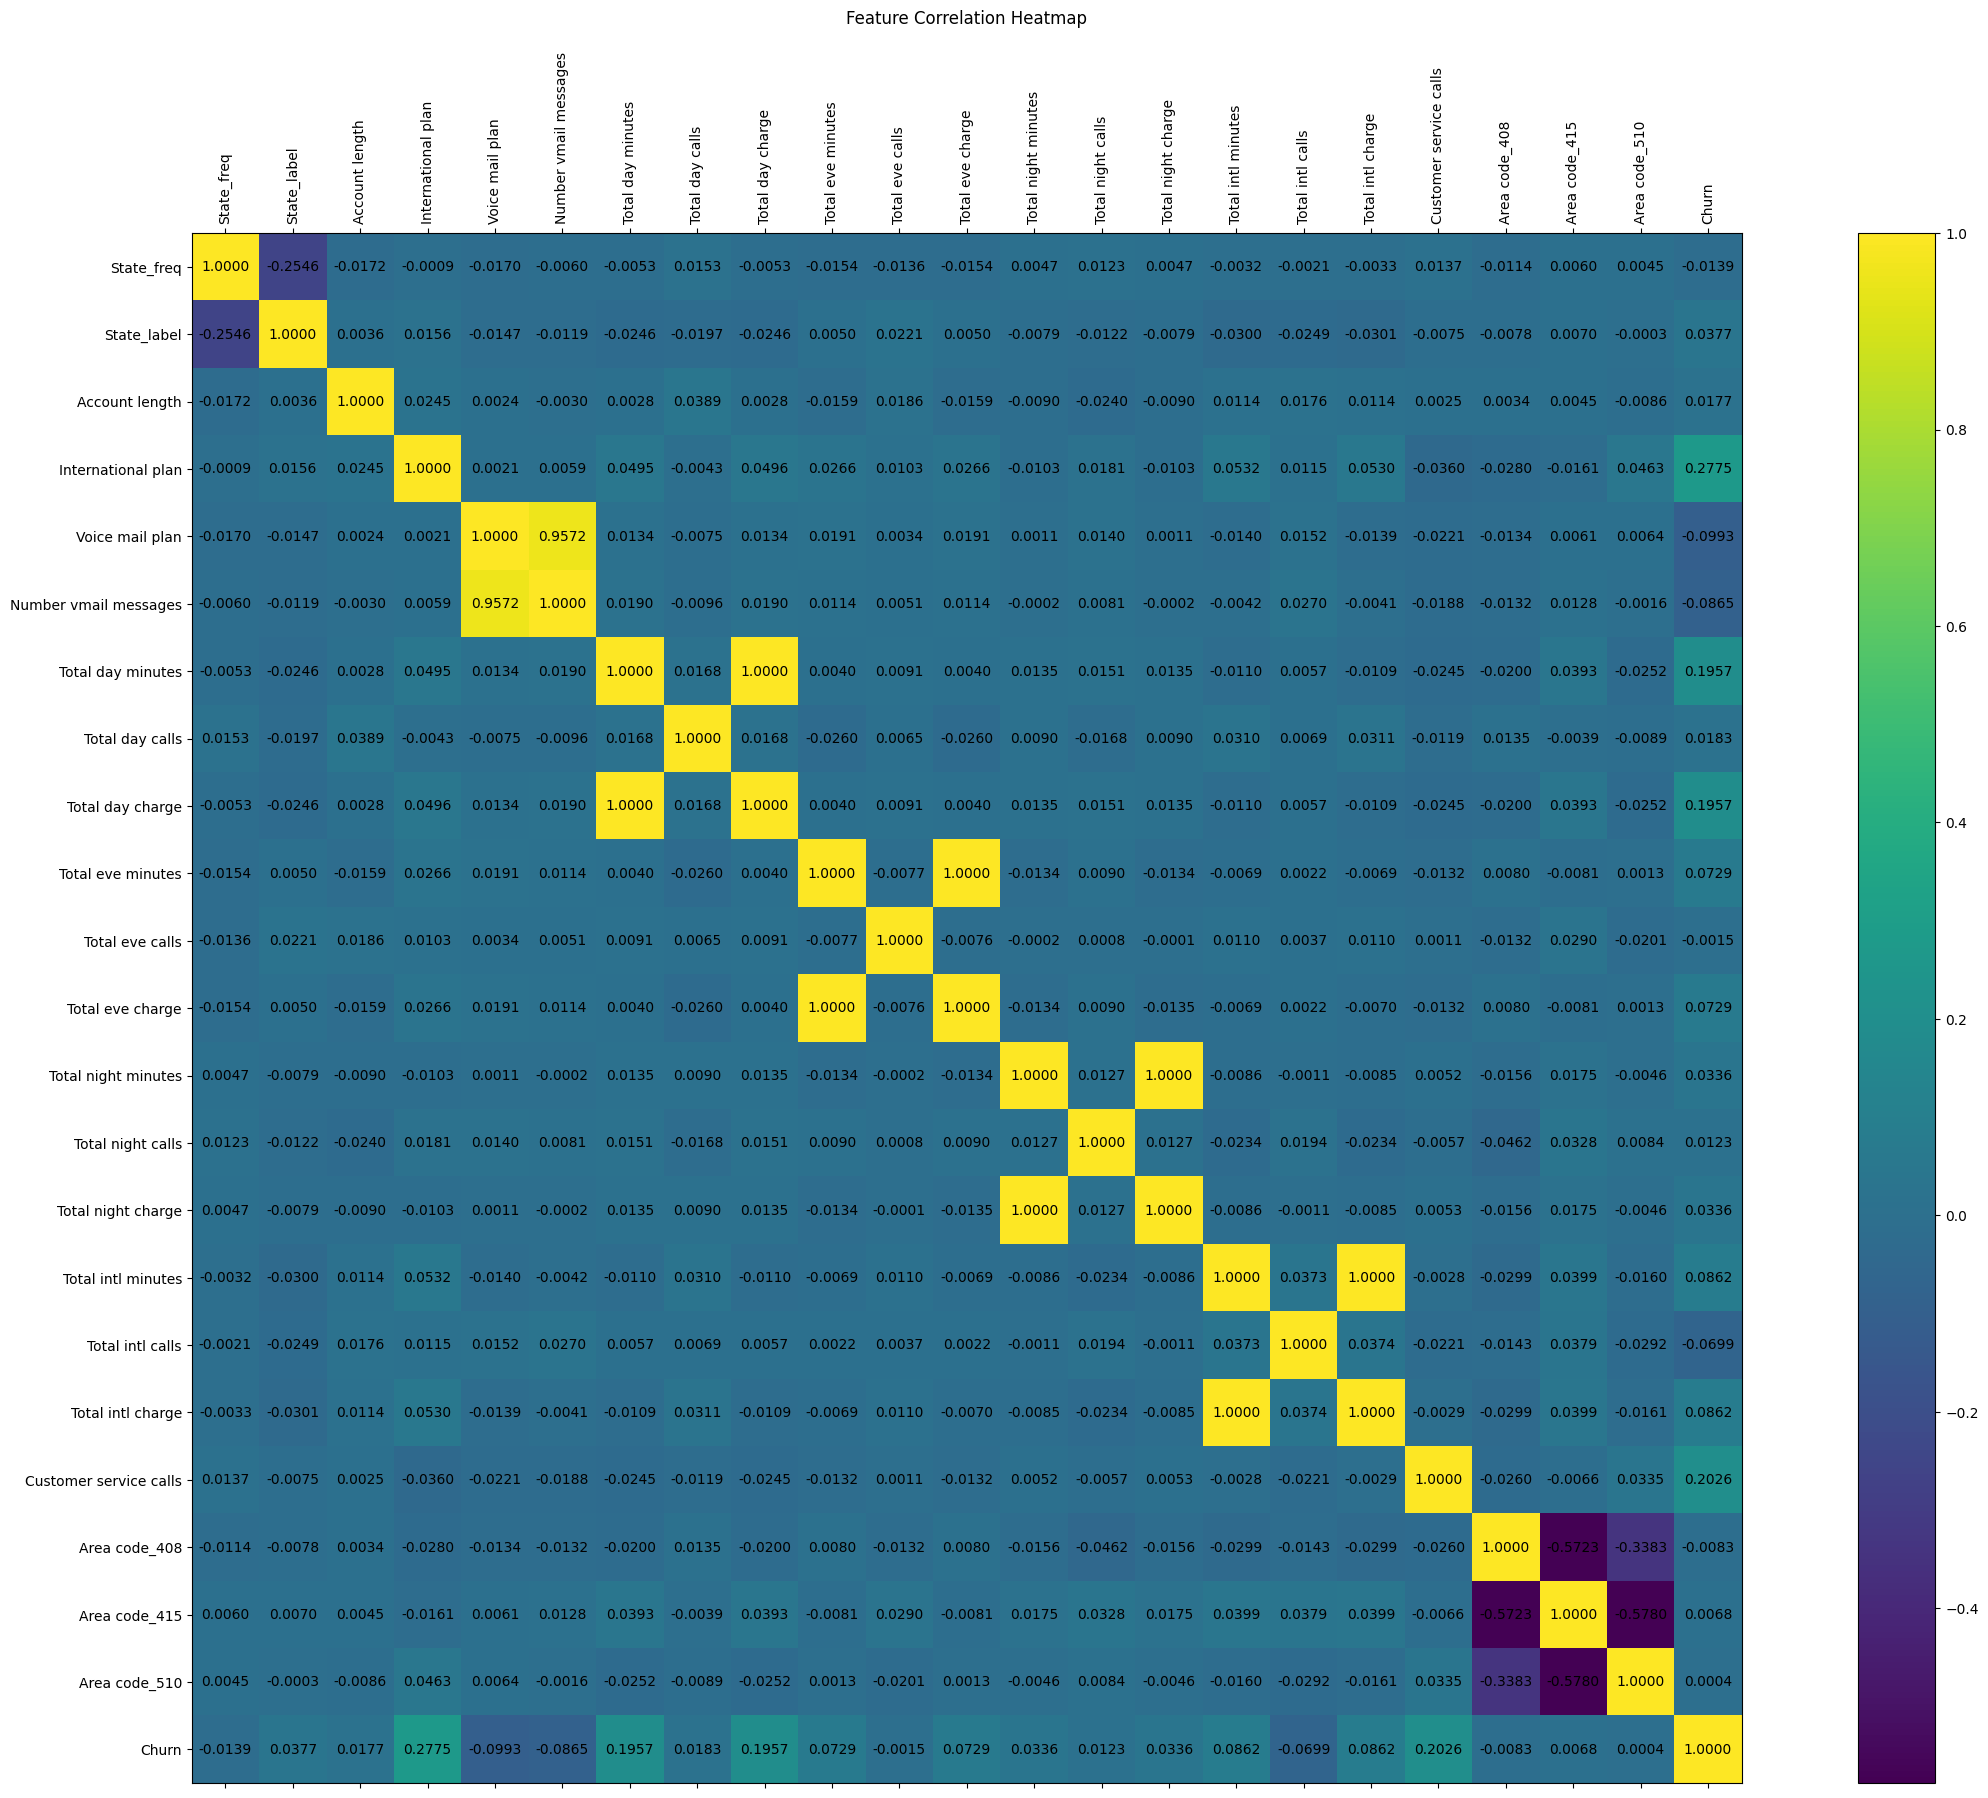

In [32]:
correlation = standard_train_df.corr()
plt.figure(figsize=(30, 20))
plt.matshow(correlation, fignum=1)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation='vertical')
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()
for i in range(len(correlation.columns)):
    for j in range(len(correlation.columns)):
        plt.text(j, i, f"{correlation.iloc[i, j]:.4f}", ha='center', va='center', color='black')

plt.title("Feature Correlation Heatmap", pad=20)
plt.show()

#### Drop features with high correlation

In [33]:
columns_to_drop = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Voice mail plan']
min_max_train_df = min_max_train_df.drop(columns=columns_to_drop)
standard_train_df = standard_train_df.drop(columns=columns_to_drop)
min_max_test_df = min_max_test_df.drop(columns=columns_to_drop)
standard_test_df = standard_test_df.drop(columns=columns_to_drop)

#### Perform PCA

To remove the least useful 5 features in terms of variance explained

In [34]:
from sklearn.decomposition import PCA

X = min_max_train_df.drop(columns='Churn')
pca = PCA(n_components=X.shape[1]) 
X_pca = pca.fit_transform(X)

# Identifying the least useful 5 features
explained_variance = pca.explained_variance_ratio_
least_useful_indices = np.argsort(explained_variance)[:5]  
least_useful_features = [X.columns[i] for i in least_useful_indices]
least_useful_features

['Area code_510',
 'Area code_415',
 'Area code_408',
 'Customer service calls',
 'Total intl calls']

In [35]:
X = standard_train_df.drop(columns='Churn')
pca = PCA(n_components=X.shape[1]) 
X_pca = pca.fit_transform(X)

# Identifying the least useful 5 features
explained_variance = pca.explained_variance_ratio_
least_useful_indices = np.argsort(explained_variance)[:5]  
least_useful_features = [X.columns[i] for i in least_useful_indices]
least_useful_features

['Area code_510',
 'Area code_415',
 'Area code_408',
 'Customer service calls',
 'Total intl calls']

In [36]:
min_max_train_df = min_max_train_df.drop(columns=least_useful_features)
standard_train_df = standard_train_df.drop(columns=least_useful_features)
min_max_test_df = min_max_test_df.drop(columns=least_useful_features)
standard_test_df = standard_test_df.drop(columns=least_useful_features)

dataests['min_max_scale_pca'] = {}
dataests['standard_scale_pca'] = {}
dataests['min_max_scale_pca']['train'] = min_max_train_df
dataests['standard_scale_pca']['train'] = standard_train_df
dataests['min_max_scale_pca']['test'] = min_max_test_df
dataests['standard_scale_pca']['test'] = standard_test_df

with open('./dataset/cleaned_datasets.pkl', 'wb') as f:
    pickle.dump(dataests, f)